# Smart Usage Analytics

In [2]:
# Imports & config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import timedelta
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 160)
sns.set(style='whitegrid')


In [3]:
df = pd.read_csv("/content/final_fg_events.csv")
print('Raw rows:', len(df))
df.head(5)


Raw rows: 54038


,person_id,start_dt,end_dt,event_name,usage_sec
0,1,8/1/2022 14:27,8/1/2022 14:28,GPay,29
1,1,8/1/2022 14:30,8/1/2022 14:31,Instagram,52
2,1,8/1/2022 14:32,8/1/2022 14:32,GPay,35
3,1,8/1/2022 14:39,8/1/2022 14:40,Instagram,65
4,1,8/1/2022 14:42,8/1/2022 14:46,YouTube,252


In [4]:
df['start_dt'] = pd.to_datetime(df['start_dt'])
df['end_dt']   = pd.to_datetime(df['end_dt'])

In [5]:

# --- Reusable utility functions ---

def group_usage(df, by, seconds_to='min'):
    '''Group by columns in `by` and return usage aggregated. seconds_to='min'|'hours'|'sec' '''
    temp = df.groupby(by)['usage_sec'].sum().reset_index()
    if seconds_to == 'min':
        temp['usage_min'] = temp['usage_sec'] / 60
    elif seconds_to == 'hours':
        temp['usage_hr'] = temp['usage_sec'] / 3600
    return temp

def top_n_apps(df, n=5, person_id=None):
    '''Return top-n apps by usage. If person_id given, filter first.'''
    sub = df if person_id is None else df[df['person_id']==person_id]
    out = sub.groupby('event_name')['usage_sec'].sum().reset_index().sort_values('usage_sec', ascending=False).head(n)
    out['usage_min'] = out['usage_sec']/60
    return out

def avg_daily_per_person(df):
    daily = group_usage(df, ['person_id','date'], seconds_to='sec')
    summary = daily.groupby('person_id')['usage_sec'].agg(['mean','std']).reset_index().rename(columns={'mean':'avg_daily_sec','std':'std_daily_sec'})
    summary['avg_daily_min'] = summary['avg_daily_sec']/60
    summary['std_daily_min'] = summary['std_daily_sec']/60
    return summary

def peak_hours(df):
    hour = group_usage(df, ['hour'], seconds_to='sec')
    hour = hour.sort_values('usage_sec', ascending=False)
    return hour

def detect_sleep_periods(df, min_sleep_hours=3, ignore_small_min=45):
    '''
    Detect long inactivity gaps per person that likely represent sleep.
    Returns DataFrame with person_id, date (based on night), sleep_time (end of last use), wake_time (next start), gap.
    '''
    data = df.sort_values(['person_id','start_dt']).copy()
    data['next_start'] = data.groupby('person_id')['start_dt'].shift(-1)
    data['gap'] = data['next_start'] - data['end_dt']
    MIN_SLEEP = pd.Timedelta(hours=min_sleep_hours)
    IGNORE_SMALL = pd.Timedelta(minutes=ignore_small_min)
    data['is_sleep_candidate'] = (data['gap'] >= MIN_SLEEP) & (data['end_dt'].dt.hour.isin(list(range(19,24))+list(range(0,5))))
    # pick largest gap per person-date (date anchored to end_dt date)
    data['date'] = data['end_dt'].dt.date
    sleep_df = data[data['is_sleep_candidate']].sort_values(['person_id','date','gap'], ascending=[True,True,False])
    sleep_df = sleep_df.groupby(['person_id','date']).head(1).reset_index(drop=True)
    # rename columns
    sleep_df = sleep_df.rename(columns={'end_dt':'sleep_time','next_start':'wake_time'})
    # calculate durations
    sleep_df['sleep_duration'] = sleep_df['wake_time'] - sleep_df['sleep_time']
    # filter typical wake before afternoon
    sleep_df = sleep_df[sleep_df['wake_time'].dt.hour <= 15]
    return sleep_df[['person_id','date','sleep_time','wake_time','sleep_duration','gap']]


,person_id,avg_daily_sec,std_daily_sec,avg_daily_min,std_daily_min
0,12,15968.177778,5604.025462,266.136296,93.400424
1,10,13516.139535,4589.478742,225.268992,76.491312
2,11,13499.227273,6562.122246,224.987121,109.368704
3,8,13486.111111,8183.793234,224.768519,136.396554
4,14,13212.000000,5765.018605,220.200000,96.083643
5,7,12657.000000,7099.823935,210.950000,118.330399
6,16,12597.848485,5579.237538,209.964141,92.987292
7,2,10059.658537,6734.589789,167.660976,112.243163
8,15,9959.818182,5480.639638,165.996970,91.343994
9,4,9048.142857,6937.460056,150.802381,115.624334


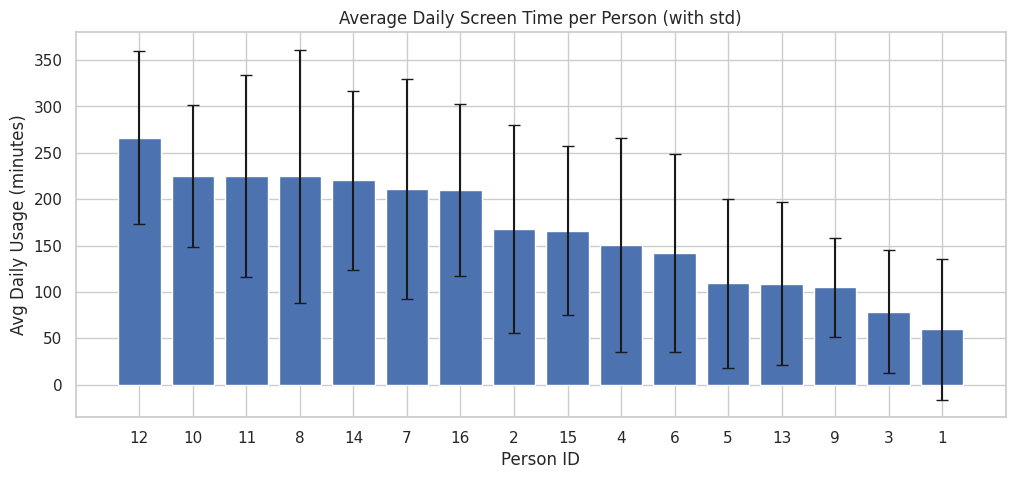

/tmp/ipython-input-3314805236.py:36: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




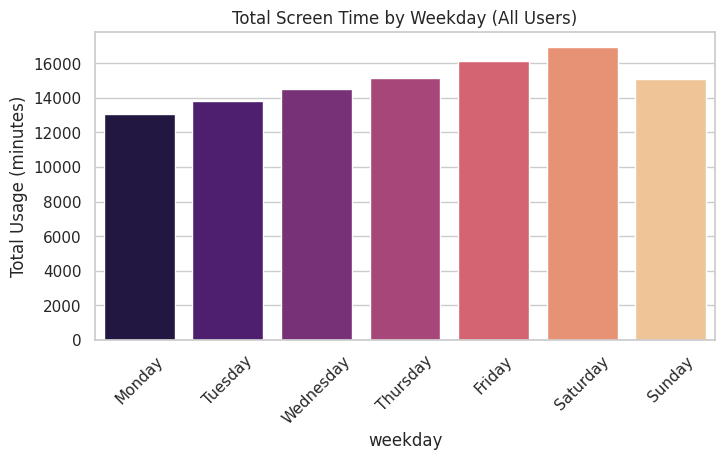

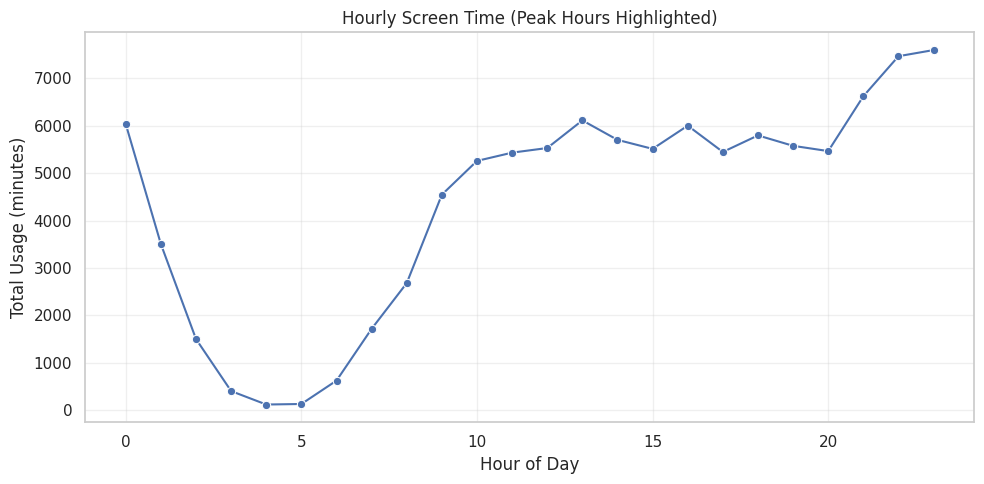

,event_name,usage_sec,usage_min
205,WhatsApp,1449371,24156.183333
89,Instagram,1370246,22837.433333
208,YouTube,1107063,18451.050000
82,Hotstar,265567,4426.116667
76,Gmail,194147,3235.783333


/tmp/ipython-input-3314805236.py:59: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




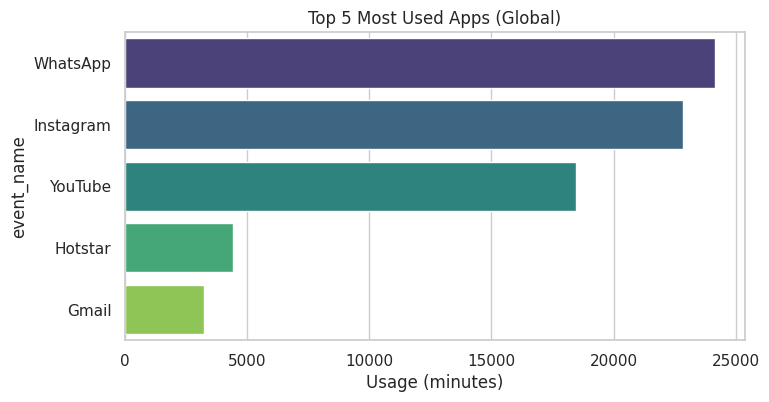

In [15]:
# ---------------------------------------------------------
# BASIC PREP (already in your code)
# ---------------------------------------------------------
df['date'] = df['start_dt'].dt.date
df['hour'] = df['start_dt'].dt.hour
df['weekday'] = df['start_dt'].dt.day_name()

# ---------------------------------------------------------
# SCREEN TIME ANALYSIS (your existing code)
# ---------------------------------------------------------

# 1) Average daily per person (with std)
summary = avg_daily_per_person(df)
summary = summary.sort_values('avg_daily_min', ascending=False).reset_index(drop=True)
display(summary.head(10))

plt.figure(figsize=(12,5))
plt.bar(
    summary['person_id'].astype(str),
    summary['avg_daily_min'],
    yerr=summary['std_daily_min'],
    capsize=4
)
plt.xlabel('Person ID')
plt.ylabel('Avg Daily Usage (minutes)')
plt.title('Average Daily Screen Time per Person (with std)')
plt.show()

# 2) Weekday totals (global)
weekday_totals = group_usage(df, ['weekday'], seconds_to='min')
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_totals['weekday'] = pd.Categorical(weekday_totals['weekday'], categories=weekday_order, ordered=True)
weekday_totals = weekday_totals.sort_values('weekday')

plt.figure(figsize=(8,4))
sns.barplot(data=weekday_totals, x='weekday', y='usage_min', palette='magma')
plt.xticks(rotation=45)
plt.ylabel('Total Usage (minutes)')
plt.title('Total Screen Time by Weekday (All Users)')
plt.show()

# 3) Hourly pattern (global)
hourly_usage = group_usage(df, ['hour'])

plt.figure(figsize=(10,5))
sns.lineplot(data=hourly_usage, x='hour', y='usage_min', marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Total Usage (minutes)")
plt.title("Hourly Screen Time (Peak Hours Highlighted)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Top 5 apps globally
top5_global = top_n_apps(df, n=5, person_id=None)
display(top5_global)

plt.figure(figsize=(8,4))
sns.barplot(data=top5_global, x='usage_min', y='event_name', palette='viridis')
plt.xlabel('Usage (minutes)')
plt.title('Top 5 Most Used Apps (Global)')
plt.show()

# 5) Top 5 per person (Plotly small grid)
import plotly.subplots as psub
persons = sorted(df['person_id'].dropna().unique())[:6]

fig = psub.make_subplots(
    rows=2, cols=3,
    subplot_titles=[f'Person {p}' for p in persons]
)

r, c = 1, 1
for p in persons:
    top5 = top_n_apps(df, n=5, person_id=p).sort_values('usage_min', ascending=True)
    fig.add_trace(
        go.Bar(x=top5['usage_min'], y=top5['event_name'], orientation='h'),
        row=r, col=c
    )
    c += 1
    if c > 3:
        r += 1
        c = 1

fig.update_layout(
    height=700,
    width=1000,
    title_text='Top 5 Apps for Selected Persons (minutes)'
)
fig.show()

# =====================================================================
# ✅ **ADDING PIE CHART (PER-PERSON — WITH DROPDOWN)**
# =====================================================================

import plotly.graph_objects as go

# ---- compute app usage (simple sum) ----
app_usage = (
    df.groupby(["person_id", "event_name"])["usage_sec"]
      .sum()
      .reset_index()
)

persons = sorted(app_usage["person_id"].unique())

fig = go.Figure()

# ---- create PIE trace for each person (only first visible) ----
for i, pid in enumerate(persons):
    sub = app_usage[app_usage["person_id"] == pid]

    # Optional: collapse small apps into "Others"
    sub = sub.sort_values("usage_sec", ascending=False)
    if len(sub) > 8:
        top = sub.head(7)
        other_val = sub.iloc[7:]['usage_sec'].sum()
        other_row = pd.DataFrame({"event_name": ["Other"], "usage_sec": [other_val]})
        sub = pd.concat([top, other_row])

    fig.add_trace(
        go.Pie(
            labels=sub["event_name"],
            values=sub["usage_sec"],
            name=f"Person {pid}",
            hole=0.35,
            visible=(i == 0),
            hovertemplate="<b>%{label}</b><br>Usage: %{value} sec<extra></extra>"
        )
    )

# ---- dropdown buttons ----
buttons = []
for i, pid in enumerate(persons):
    vis = [False] * len(persons)
    vis[i] = True

    buttons.append(
        dict(
            label=f"Person {pid}",
            method="update",
            args=[
                {"visible": vis},
                {"title": f"App Usage Ratio — Person {pid}"}
            ]
        )
    )

# ---- layout ----
fig.update_layout(
    title=f"App Usage Ratio — Person {persons[0]}",
    updatemenus=[
        dict(
            active=0,
            buttons=buttons,
            x=1.15,
            y=1,
            xanchor="left"
        )
    ],
    height=600,
)

fig.show()


In [16]:
import plotly.graph_objects as go
import pandas as pd

# ---------------------------------------------------------
# TOTAL USAGE PER PERSON (simple sum of all usage_sec)
# ---------------------------------------------------------
person_total = (
    df.groupby("person_id")["usage_sec"]
      .sum()
      .reset_index()
      .sort_values("usage_sec", ascending=False)
)

person_total["usage_min"] = person_total["usage_sec"] / 60

# ---------------------------------------------------------
# PLOTLY PIE CHART – SHARE OF TOTAL USAGE
# ---------------------------------------------------------
fig = go.Figure()

fig.add_trace(
    go.Pie(
        labels=person_total["person_id"],
        values=person_total["usage_sec"],
        hole=0.35,
        hovertemplate="<b>Person %{label}</b><br>Total: %{value} sec<extra></extra>"
    )
)

fig.update_layout(
    title="Total Usage Ratio of Each Person (Share of Total Screen Time)",
    height=600
)

fig.show()


dasasd


dasda


#####dasdad